In [1]:
from thejoker.data import RVData
from thejoker.sampler import JokerParams, TheJoker
from thejoker.plot import plot_rv_curves
import astropy.units as u
import schwimmbad
import numpy as np
import matplotlib.pyplot as plt

t, rv, err = np.loadtxt('data/kic10080943a_JDrv.txt', usecols=(0,1,2), delimiter=',').T
# t, rv, err = np.loadtxt('data/kic10080943a_JDrv.txt', delimiter=',', usecols=(0,1,2)).T
# t -= t[0]
t += 2400000
t -= 2454833

rv *= u.km/u.s
err *= u.km/u.s 

INFO: 1 good sample after rejection sampling [thejoker.sampler.sampler]


Text(0, 0.5, '$K$ [km/s]')

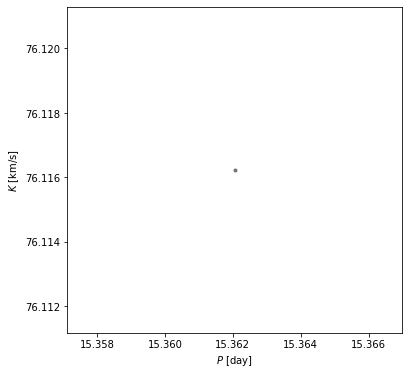

In [2]:
data = RVData(t=t, rv=rv, stddev=err)
params = JokerParams(P_min=5*u.day, P_max=50*u.day)
pool = schwimmbad.MultiPool()
joker = TheJoker(params, pool=pool)

samples = joker.rejection_sample(data, n_prior_samples=100000)

fig, ax = plt.subplots(1, 1, figsize=(6,6)) # doctest: +SKIP
ax.scatter(samples['P'].value, samples['K'].to(u.km/u.s).value,
           marker='.', color='k', alpha=0.45) # doctest: +SKIP
ax.set_xlabel("$P$ [day]")
ax.set_ylabel("$K$ [km/s]")

In [3]:
samples

JokerSamples([('P', <Quantity [15.36205252] d>),
              ('M0', <Quantity [1.82884668] rad>),
              ('e', <Quantity [0.32978451]>),
              ('omega', <Quantity [2.80636357] rad>),
              ('jitter', <Quantity [0.] km / s>),
              ('K', <Quantity [76.11623882] km / s>),
              ('v0', <Quantity [-29.24580686] km / s>)])

In [4]:
0.05 * np.sin(4.02)

-0.03848615703820119

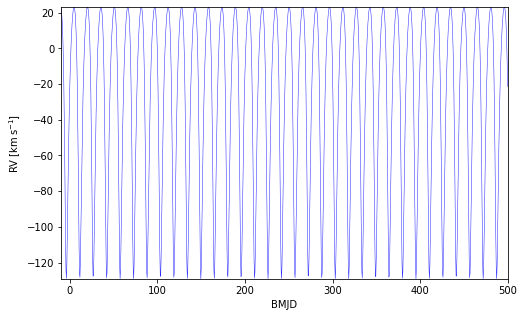

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
t_grid = np.linspace(-10, 500, 1024)
plot_rv_curves(samples[:100], t_grid, rv_unit=u.km/u.s, data=data, ax=ax,
               plot_kwargs=dict(color='blue'));

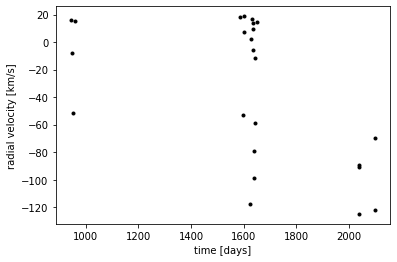

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = t
y = rv.value
# y -= np.mean(y)
yerr = err.value

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]");

In [7]:
import exoplanet as xo

period = samples['P'].value
period_err = [0.1]
t0s = [0]
t0_errs = [0.0007]
Ks = samples['K'].value
v0 = samples['v0'].value[0]

In [8]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    t0 = pm.Uniform('t0', lower=0, upper=100, testval=20)
    P = pm.Bound(pm.Normal, lower=0)("P", mu=period[0], sd=0.1,
                                     shape=1, testval=period[0])

    # Wide log-normal prior for semi-amplitude
    logK = pm.Bound(pm.Normal, lower=0)("logK", mu=np.log(Ks[0]), sd=10.0,
                                        shape=1, testval=np.log(Ks[0]))

    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.0001)
    omega = xo.distributions.Angle("omega", shape=1)

    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)

    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t_periastron=t0,
        ecc=ecc, omega=omega)
#     t_per = pm.Deterministic('t_per', orbit.t_periastron)
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    
    # Define the background model
#     trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=1)
#     A = np.vander(x - 0.5*(x.min() + x.max()), 1)
#     bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=v0)
#     bkg = pm.Uniform('gammav', lower=-50, upper=50, testval=-12)
    rv_model = pm.Deterministic("rv_model", vrad + 0 + gammav)
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

In [9]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK)) + gammav
    pm.Deterministic("vrad_pred", vrad_pred)

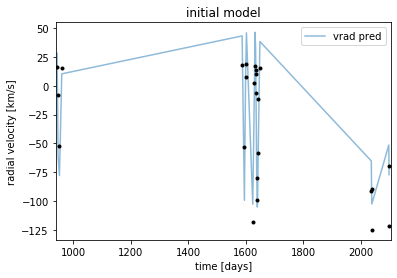

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(x, xo.eval_in_model(rv_model), alpha=0.5, label='vrad pred')
#     plt.plot(t, xo.eval_in_model(vrad_pred), alpha=0.5, label='vrad pred')
plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]")
plt.title("initial model");

In [11]:
with model:
    map_soln = xo.optimize(start=model.test_point, vars=[ecc])
    map_soln = xo.optimize(start=map_soln, vars=[gammav])
    map_soln = xo.optimize(start=map_soln)
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [ecc]
12it [00:01,  9.40it/s, logp=-1.927562e+05] 
message: Optimization terminated successfully.
logp: -192771.51063183747 -> -192756.22004421699
optimizing logp for variables: [gammav]
9it [00:00, 46.90it/s, logp=-1.907379e+05]  
message: Optimization terminated successfully.
logp: -192756.22004421699 -> -190737.8572616403
optimizing logp for variables: [gammav, logs, omega, ecc, logK, P, t0]
135it [00:00, 262.39it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -190737.8572616403 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [gammav, logs, omega, ecc, logK, P, t0]
135it [00:00, 299.27it/s, logp=nan]         
message: Desired error not necessarily achieved due to precision loss.
logp: -190737.8572616403 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


In [12]:
map_soln

{'t0_interval__': array(-1.38629436),
 'P_lowerbound__': array([2.73190035]),
 'logK_lowerbound__': array([1.46608972]),
 'ecc_logodds__': array([-12.16742092]),
 'omega_angle__': array([[0.],
        [1.]]),
 'logs': array(-1.89711998),
 'gammav_interval__': array(-1.52006089),
 't0': array(20.),
 'P': array([15.36205252]),
 'logK': array([4.33226163]),
 'ecc': array([5.19701507e-06]),
 'omega': array([0.]),
 'gammav': array(-32.05474462),
 'rv_model': array([  25.17472544,  -62.40182344,  -80.60536968,    7.46184716,
          40.27809986, -102.09199902,    3.37628715,   42.97879656,
        -105.47239894,  -22.15357855,   43.4706527 ,   30.64274452,
           7.33922502,  -26.26852777,  -79.96483212, -107.8925864 ,
        -103.90329193,  -63.88204101,   35.45432709,  -67.96990768,
         -92.20109848, -105.20961491,  -54.18876783,  -79.80669649]),
 'vrad_pred': array([ -13.54341614,   18.30663246,   38.89814922,   43.62757576,
          31.43756403,    5.05340188,  -29.62636137,

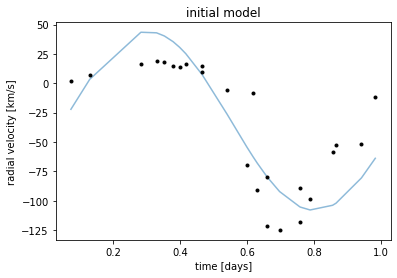

In [13]:

plt.errorbar(x % map_soln['P'] / map_soln['P'], y, yerr=yerr, fmt=".k")

with model:
    x_sort = x % map_soln['P'] / map_soln['P']
    sort = np.argsort(x_sort)
    plt.plot(x_sort[sort], xo.eval_in_model(rv_model, map_soln)[sort], alpha=0.5)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [km/s]")
plt.title("initial model");

In [14]:
np.random.seed(42)
with model: 
    trace = pm.sample(tune=2000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.95))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammav, logs, omega, ecc, logK, P, t0]
Sampling 2 chains: 100%|██████████| 6000/6000 [01:38<00:00, 60.94draws/s] 
The acceptance probability does not match the target. It is 0.9933487371609235, but should be close to 0.95. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
res = pm.summary(trace, varnames=["logs", "omega", "ecc", "t0", "logK", "P", 'gammav'])
res

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs,0.984634,0.990616,0.097536,-0.280106,2.256698,1.019080,7.677786
omega__0,1.734342,2.426806,0.124979,-3.119897,3.140733,3.289520,1.253786
ecc__0,0.452789,0.018834,0.000370,0.411589,0.495974,1594.395945,1.001609
t0,6.909990,6.825380,0.682501,0.001281,13.814749,1.000565,128.299817
logK__0,4.254128,0.030626,0.001874,4.176958,4.289500,2.108946,1.445458
P__0,15.330663,0.005695,0.000563,15.323256,15.337127,1.014405,8.852036
gammav,-21.912663,1.516308,0.107683,-23.656173,-18.401975,1.612722,1.698777


In [16]:
(np.mean(trace['P']) * 86400) * np.sqrt(1 - np.mean(trace['ecc'])**2) * (np.exp(np.mean(trace['logK'])) * 1000) / (2*np.pi) / 299792458

44.13642259336857

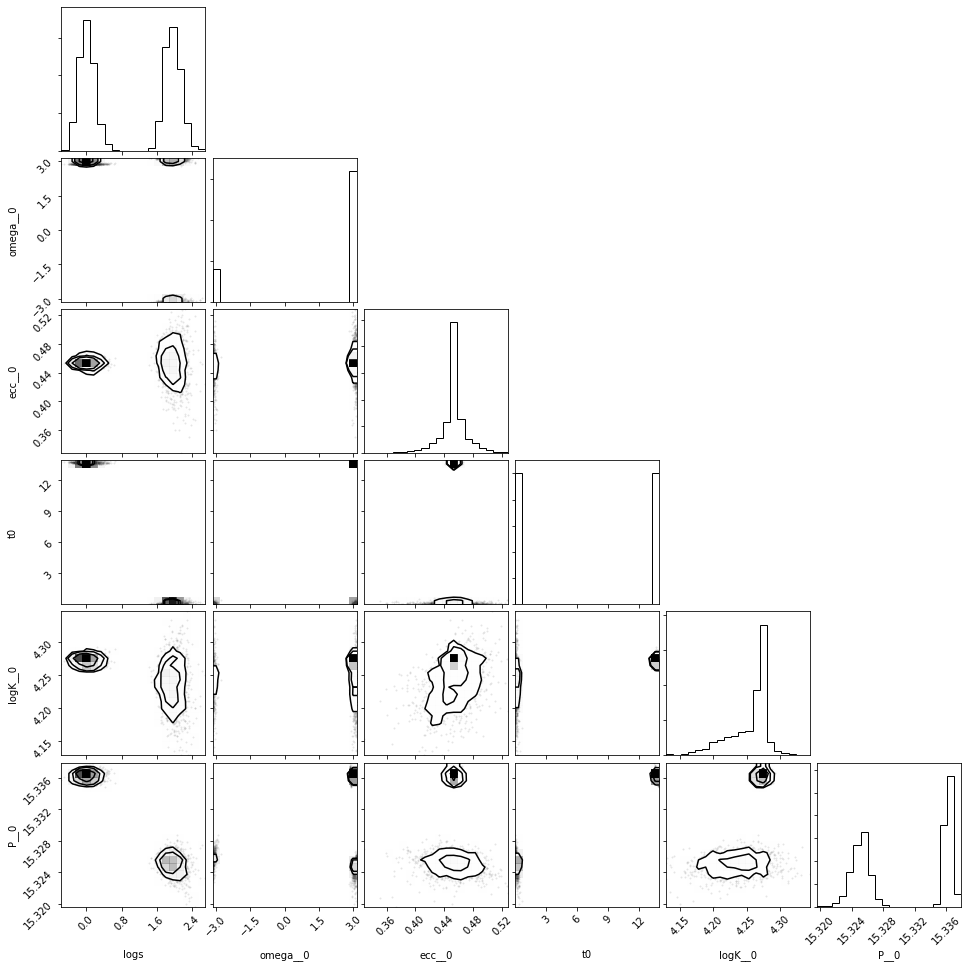

In [17]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=["logs", "omega", "ecc", "t0", "logK", "P"]));

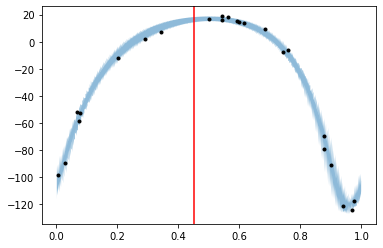

In [18]:
med = np.mean(trace['vrad_pred'], axis=0)
sd = np.std(trace['vrad_pred'], axis=0)
t = np.linspace(x.min()-5, x.max()+5, 1000)


times = t % np.mean(trace['P']) / np.mean(trace['P'])
sort = np.argsort(times)
plt.fill_between(times[sort], (med-sd)[sort], (med+sd)[sort], alpha=0.5)

plt.errorbar(x % np.mean(trace['P']) / np.mean(trace['P']), y, yerr=yerr, fmt=".k")
plt.axvline(np.mean(trace['t0']) % np.mean(trace['P']) / np.mean(trace['P']), c='r')

In [20]:
np.mean(trace['t0']) % np.mean(trace['P']) / np.mean(trace['P'])

0.45073000934944984

In [24]:
plt.figure(figsize=[10,7])

plt.errorbar(x % np.mean(trace['P']) / np.mean(trace['P']), y, yerr=yerr, fmt=".", c='red', markersize=10, zorder=5)

with model:
    for sample in xo.get_samples_from_trace(trace, 1000):
        
        tt = t % sample['P'] / sample['P']
        sort = np.argsort(tt)
        plt.plot(tt[sort], sample['vrad_pred'][sort], alpha=0.1, label='vrad pred', linewidth=0.1, c='blue', zorder=1)
        

plt.xlabel('Orbital phase')
plt.ylabel('RV [km/s]')

NameError: name 'trace' is not defined

<Figure size 720x504 with 0 Axes>

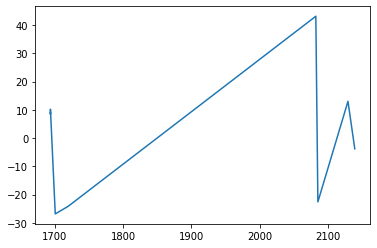

In [32]:
x, y, yerr = np.loadtxt('data/kic6780873_JDrv.txt', usecols=(0,1,2), delimiter=',').T
x += 2400000
x -= 2454833
plt.plot(x,y)

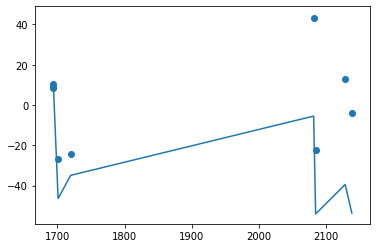

In [33]:
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    P = pm.Bound(pm.Normal, lower=0, upper=12)("P", mu=period, sd=1,
                                     shape=1, testval=period)

    # Wide log-normal prior for semi-amplitude
    logasini = pm.Bound(pm.Normal, lower=0)("logasini", mu=np.log(18), sd=10.0,
                                        shape=1, testval=np.log(18))
    asini = pm.Deterministic('asini', tt.exp(logasini))
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    # Eccentricity & argument of periasteron
    ecc = xo.distributions.UnitUniform("ecc", shape=1, testval=0.01)
    omega = xo.distributions.Angle("omega", shape=1)
    gammav = pm.Uniform('gammav', lower=-50, upper=50, testval=-13)
    
    t0 = pm.Normal('t0', mu=0., sd=10, testval=0.1)    
    sinw = tt.sin(omega)
    cosw = tt.cos(omega)
    opsw = 1 + sinw
    E0 = 2 * tt.arctan2(tt.sqrt(1-ecc)*cosw, tt.sqrt(1+ecc)*opsw)
    M0 = E0 - ecc * tt.sin(E0)
    tref = pm.Deterministic("tref", t0 - M0 * P / (2*np.pi))
    
    # Mean anom
    M = 2.0 * np.pi * (x - tref) / P

#     phi = xo.distributions.Angle('phi', testval=0.)
#     M = 2. * np.pi * x / P - phi
    # True anom
    f = get_true_anomaly(M, ecc + tt.zeros_like(M))
    vrad = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f + omega) + ecc*tt.cos(omega))
    vrad *= 299792.458  # c in km/s
    vrad += gammav # Systemic velocity
    err = tt.sqrt(2*yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=vrad, sd=err, observed=y)
    
    plt.plot(x, xo.eval_in_model(vrad))
    plt.scatter(x, y)
    
    
t = np.linspace(x.min()-5, x.max()+5, 1000)
with model:
    M2 = 2. * np.pi * t / P - phi
    f2 = get_true_anomaly(M2, ecc + tt.zeros_like(M2))
    vrad2 = -2.0 * np.pi * ((tt.exp(logasini) / 86400) / P) * (1/tt.sqrt(1.0 - tt.square(ecc))) * (tt.cos(f2 + omega) + ecc*tt.cos(omega))
    vrad2 *= 299792.458  # c in km/s|
    vrad2 += gammav # Systemic velocity
    pm.Deterministic("vrad_pred", vrad2)

In [34]:
with model:
    map_soln = xo.optimize(start=model.test_point)
    map_soln = xo.optimize(start=map_soln, vars=[gammav])
    map_soln = xo.optimize(start=map_soln, vars=[t0])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [t0, gammav, omega, ecc, logs, logasini, P]
874it [00:01, 474.50it/s, logp=-2.296800e+01]

MissingInputError: Input 0 of the graph (indices start from 0), used to compute Subtensor{int64}(phi_angle__, Constant{1}), was not provided and not given a value. Use the Theano flag exception_verbosity='high', for more information on this error.

In [ ]:
with model:
    plt.scatter(x,y)
    plt.plot(x, xo.eval_in_model(vrad,map_soln))

875it [00:20, 474.50it/s, logp=-2.296800e+01]

In [24]:
map_soln

{'P_interval__': array([1.18492584]),
 'logasini_lowerbound__': array([1.01247518]),
 'logs': array(-0.80187285),
 'ecc_logodds__': array([-0.97482595]),
 'omega_angle__': array([[ 0.8592069 ],
        [-4.38882254]]),
 'gammav_interval__': array(-0.01806826),
 'phi_angle__': array([ 1.17650019, -4.31460827]),
 'P': array([9.18998792]),
 'logasini': array([2.75240528]),
 'asini': array([15.68030203]),
 'ecc': array([0.27391963]),
 'omega': array([2.94826613]),
 'gammav': array(-0.4516942),
 'phi': array(2.87538616),
 'vrad_pred': array([-1.31150108e+01, -1.91450954e+01, -2.35787433e+01, -2.65994622e+01,
        -2.83048466e+01, -2.87056220e+01, -2.77204211e+01, -2.51619206e+01,
        -2.07145274e+01, -1.39144430e+01, -4.18042337e+00,  8.93976882e+00,
         2.48927541e+01,  4.02871827e+01,  4.83942294e+01,  4.49329934e+01,
         3.33223721e+01,  1.95198257e+01,  6.89838419e+00, -3.54198183e+00,
        -1.18040953e+01, -1.81563022e+01, -2.28690480e+01, -2.61413350e+01,
        -

Text(0, 0.5, 'RV')

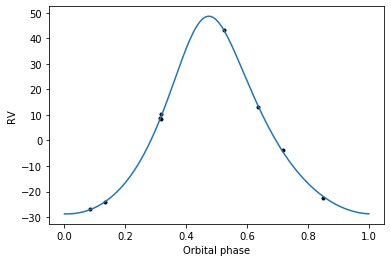

In [14]:
with model:
    plt.plot(x % map_soln['P'] / map_soln['P'],y, '.k')
    t_fold = t % map_soln['P'] / map_soln['P']
    sort = np.argsort(t_fold)
    plt.plot(t_fold[sort], xo.eval_in_model(vrad2,map_soln)[sort])
    
plt.xlabel('Orbital phase')
plt.ylabel('RV')


In [72]:
%run paper/setup.py

In [19]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=3000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.95), start=map_soln)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi, gammav, omega, ecc, logs, logasini, P]
Sampling 2 chains: 100%|██████████| 8000/8000 [12:41<00:00, 10.50draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logs,-0.017341,0.430016,0.022128,-0.814090,0.813369,203.167719,1.017563
P__0,9.173647,0.017096,0.001505,9.146022,9.205057,57.785963,1.002596
logasini__0,2.794794,0.069156,0.005362,2.644341,2.929242,87.376994,0.999504
asini__0,16.397969,1.115828,0.085434,13.917029,18.547539,91.000326,0.999555
ecc__0,0.177356,0.109277,0.009454,0.000784,0.370703,59.844895,1.001321
...,...,...,...,...,...,...,...
vrad_pred__995,-18.910780,9.289593,0.765623,-30.191214,-0.402382,60.471451,1.006591
vrad_pred__996,-11.822130,13.539244,1.135259,-29.850319,12.286894,59.859724,1.005559
vrad_pred__997,-2.788210,17.628659,1.499242,-28.107038,26.944038,59.479234,1.004888
vrad_pred__998,7.728643,20.857360,1.796324,-26.098201,40.341766,59.293454,1.004339


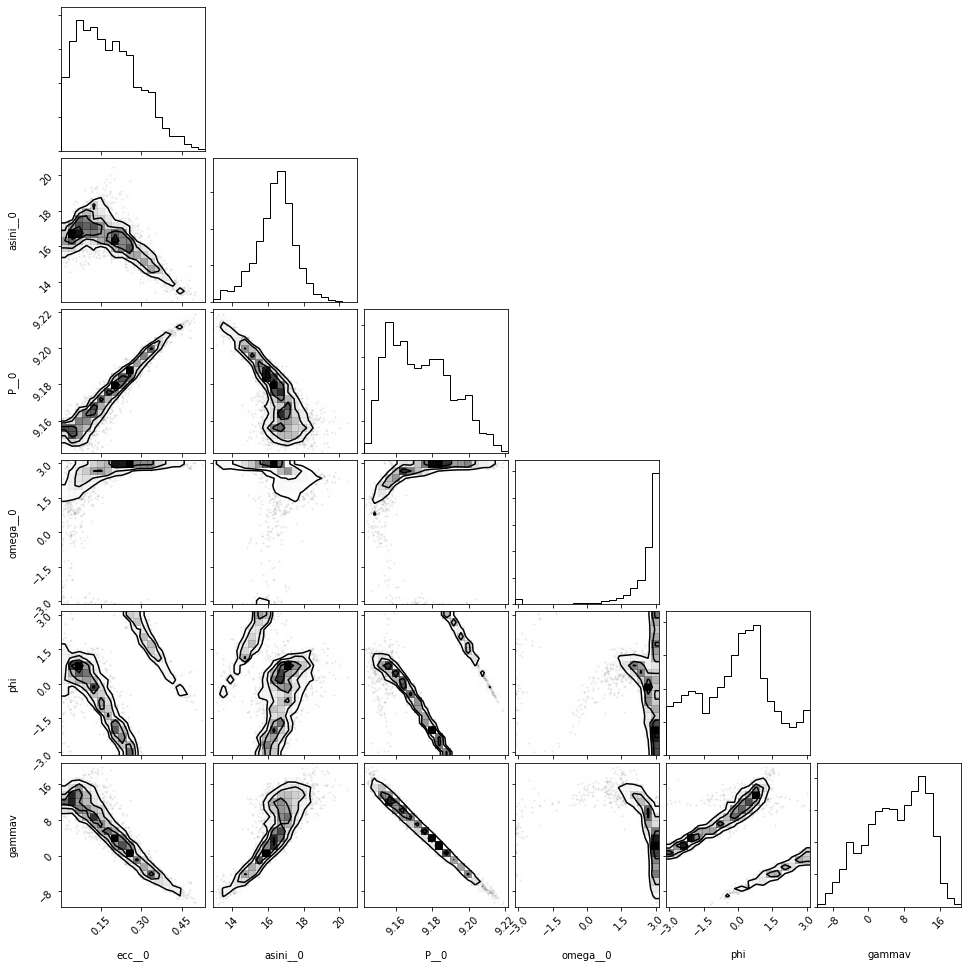

In [23]:
import corner

corner.corner(pm.trace_to_dataframe(trace, varnames=['ecc', 'asini', 'P', 'omega', 'phi', 'gammav']));

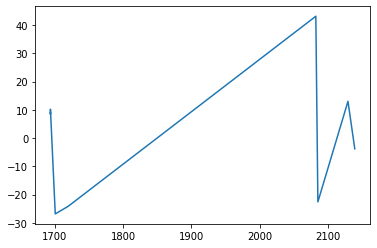

In [10]:
x, y, yerr = np.loadtxt('data/kic6780873_JDrv.txt', usecols=(0,1,2), delimiter=',').T
x += 2400000
x -= 2454833
plt.plot(x,y)
rv_jd, rv_rv = x, y

In [11]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import pymc3 as pm
import theano

rv_time_tensor = theano.shared(rv_jd)
rv_rv_tensor = theano.shared(rv_rv)

weight = True

with pm.Model() as model:
    logP = pm.Bound(pm.Normal,
                    lower=np.log(5),
                    upper=np.log(50))("logP", mu=np.log(9.15), sd=1.0,
                                      testval=np.log(9.15))
    period = pm.Deterministic("period", pm.math.exp(logP))
    # Time delay drift
#     drift_gradient = pm.Normal('drift_grad', mu=0.0, sd=0.01, shape=len(freq))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logasini = pm.Bound(pm.Normal,
                        lower=np.log(10),
                        upper=np.log(50))('logasini', mu=np.log(19.6), sd=1,
                                            testval=np.log(19.6))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega")
    #omega = pm.Uniform("omega", lower=0, upper=2*np.pi)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=1-1e-3, testval=0.003)
                
    
    # RADIAL VELOCITIES
    logs_rv = pm.Normal('logs_RV_a', mu=0., sd=10)
    gammav = pm.Normal('gammav', mu=0., sd=100.)
    rv_mean_anom = (2.0 * np.pi * rv_time_tensor / period - phi)
    rv_true_anom = get_true_anomaly(rv_mean_anom, eccen + tt.zeros_like(rv_mean_anom))
    
    rv_vrad_a = ((asini / 86400) * (-2.0 * np.pi * (1 / period) * 
                                    (1/tt.sqrt(1.0 - tt.square(eccen))) * (tt.cos(rv_true_anom + omega) + eccen*tt.cos(omega))))
    rv_vrad_a *= 299792.458  # c in km/s
    rv_vrad_a += gammav

    pm.Normal("obs_radial_velocity_a", mu=rv_vrad_a, sd=tt.exp(logs_rv), observed=rv_rv_tensor.get_value())
    

In [12]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_rv])
    map_params = xo.optimize(start=map_params, vars=[gammav])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

[phi_angle__, mean, omega_angle__, eccen_interval__, logs_RV_a, gammav]


optimizing logp for variables: [mean]
7it [00:00,  7.99it/s, logp=-3.175982e+03] 
message: Optimization terminated successfully.
logp: -3175.9818350607516 -> -3175.9818350200603
optimizing logp for variables: [logs_RV_a]
16it [00:00, 218.08it/s, logp=-6.465911e+01]
message: Optimization terminated successfully.
logp: -3175.9818350200603 -> -64.6591059987102
optimizing logp for variables: [gammav]
8it [00:00, 120.32it/s, logp=-6.321143e+01] 
message: Optimization terminated successfully.
logp: -64.6591059987102 -> -63.211426536906814
optimizing logp for variables: [omega, eccen]
18it [00:00, 230.24it/s, logp=-3.609308e+01]
message: Optimization terminated successfully.
logp: -63.211426536906814 -> -36.09308447622425
optimizing logp for variables: [phi]
10it [00:00, 154.91it/s, logp=-1.562573e+01]
message: Optimization terminated successfully.
logp: -36.09308447622425 -> -15.625732310199453
optimizing logp for variables: [gammav, logs_RV_a, eccen, omega, mean, phi]
48it [00:00, 316.38it/

In [13]:
map_params

{'logP_interval__': array(-1.03326743),
 'phi_angle__': array([4.27363552, 1.31758784]),
 'logasini_interval__': array(-0.33908029),
 'mean': array(0.00031147),
 'omega_angle__': array([ 4.08030208, -1.83061017]),
 'eccen_interval__': array(-1.77755012),
 'logs_RV_a': array(0.07045314),
 'gammav': array(17.85483381),
 'logP': array(2.21375399),
 'period': array(9.15000098),
 'phi': array(1.2717368),
 'logasini': array(2.97216422),
 'asini': array(19.53415005),
 'omega': array(1.99252348),
 'eccen': array(0.1444613)}

In [14]:
np.random.seed(42)
with model:
    trace = pm.sample(tune=1000, draws=1000, step=xo.get_dense_nuts_step(target_accept=0.95))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [gammav, logs_RV_a, eccen, omega, mean, logasini, phi, logP]
Sampling 2 chains: 100%|██████████| 4000/4000 [07:04<00:00,  9.42draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
pm.summary(trace)

/Users/danielhey/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,0.103485,10.228620,0.313928,-20.941466,19.387239,1082.498576,0.999726
logs_RV_a,0.099862,0.417137,0.022707,-0.654051,0.903698,224.359987,1.026493
gammav,7.000922,6.302968,0.537164,-6.035192,16.308731,39.108304,1.031119
logP,2.216061,0.001773,0.000153,2.213477,2.219739,35.099175,1.033961
period,9.171145,0.016272,0.001409,9.147466,9.204930,35.095917,1.033929
phi,-0.183577,1.446760,0.083585,-3.031682,2.480085,145.792081,1.006153
logasini,2.807754,0.074980,0.005589,2.633887,2.926291,99.625406,1.001335
asini,16.620184,1.287662,0.094636,13.927805,18.658300,110.393692,1.001429
omega,2.291318,1.205351,0.079326,-0.240192,3.136910,76.587524,1.026293
eccen,0.165982,0.108756,0.009189,0.000438,0.373322,35.663915,1.024514


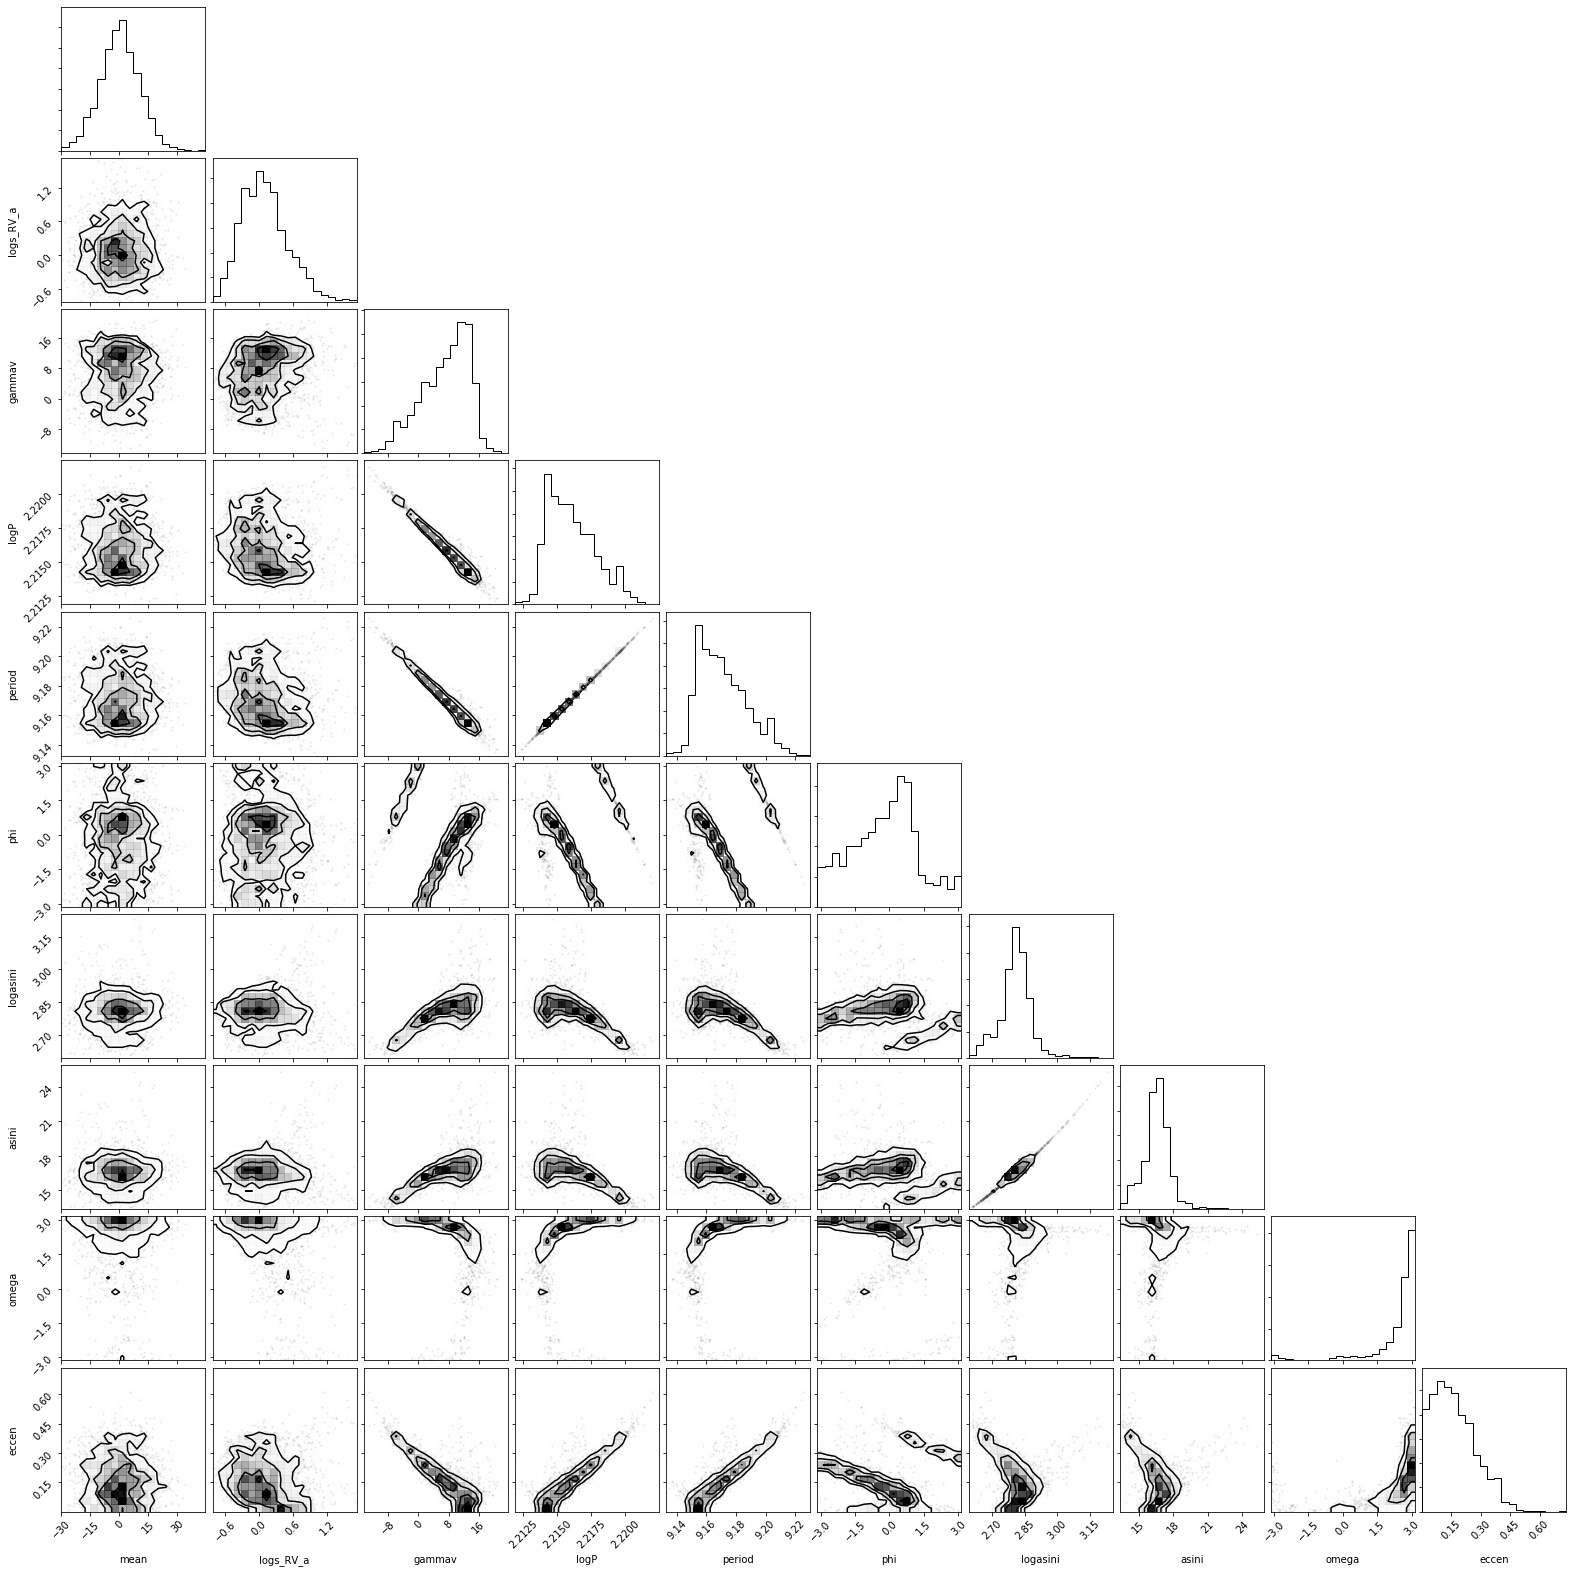

In [16]:
import corner

corner.corner(pm.trace_to_dataframe(trace));